TODO:

Obligatory
* Grid Search for lambda for auxiliary loss
* Analyse siamese net version 1
* Reduce overfitting (Look at the weights of fc3 layer of version 4 )
* Assess oversampling and undersampling, already implemented
* Try BatchNorm


Optional
* Give to model two samples: positive and negative at one time
* Look and analize where models fail
* Add learning rate scheduler

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetSiamese
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples, test_model, plot_test_results

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

Let's plot what the data is: images, class and digit values. 

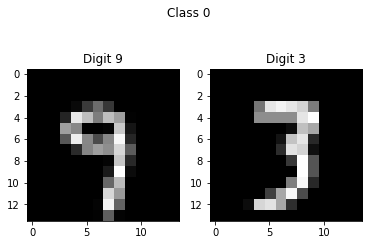

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

Let's check wheither our classes are balanced.

In [5]:
from collections import Counter

In [6]:
count_train = Counter([el.item() for el in train_class])
count_train

Counter({0: 449, 1: 551})

We see that classes are not balanced. This can lead to bias in network. There are two simple ways to do that:
* Deleting some of instances of dominating class from dataset. Cons of this procedure is that we are literally decreasing size of our dataset. However, in current situation difference in class sizes is not that big. 
* Increasing number of instances of minor class by simple copying some of already existing instances. Cons of this approach is that it may lead to overfitting, since net will see some of inctances more often that another ones. 

In [7]:
def balance_data_classes(train_input, train_class, train_digit, mode="oversampling"):
    """Balances data by over or under sampling"""
    count_train = Counter([el.item() for el in train_class])
    diff = count_train[1] - count_train[0]
    if diff == 0: # No balancing needed
        return train_input, train_class, train_digit
    
    major_class, minor_class = (1, 0) if diff > 0 else (0, 1)
    major_class_indices = [ind for ind in range(len(train_class)) if train_class[ind].item() == major_class]
    minor_class_indices = [ind for ind in range(len(train_class)) if train_class[ind].item() == minor_class]
    
    # Build new indices
    if mode == "oversampling":
        perm = torch.randperm(len(minor_class_indices))[:diff]
        indices_to_add = [minor_class_indices[ind] for ind in perm]
        minor_class_indices += indices_to_add # Adding random instances
    elif mode == "undersampling":
        major_class_indices = major_class_indices[:-diff] # Deleting some of instances
    else:
        raise NotImplementedError
    
    # Concatenate and permute indices
    new_data_indices = major_class_indices + minor_class_indices
    perm = torch.randperm(len(new_data_indices))
    new_data_indices = [new_data_indices[ind] for ind in perm]
    
    # Build new data
    train_input = train_input[new_data_indices]
    train_class = train_class[new_data_indices]
    train_digit = train_digit[new_data_indices]
    return train_input, train_class, train_digit

In [8]:
train_input, train_class, train_digit = balance_data_classes(train_input, train_class, train_digit, mode="oversampling")

Let's check wheither it worked in a way we wanted

In [9]:
count_train = Counter([el.item() for el in train_class])
count_train

Counter({0: 551, 1: 551})

In [10]:
def get_data_generator(mode=None):
    
    def generate_data(N=1000, mode=mode):
        """Generates pair datasets and returns them as DataLoader classes"""
        train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)
        if mode:
            train_input, train_class, train_digit = balance_data_classes(train_input, train_class, train_digit, mode)

        train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
        test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)
        return train_loader, test_loader
    
    return generate_data

In [11]:
generate_data = get_data_generator(mode=None) # Not applying over or under sampling technique
train_loader, test_loader = generate_data()

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [12]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [13]:
# Task specific setup
input_channels = 2
output_class_channels = 1
output_digit_channels = 10

### Simple model

First let's implement simple model. It;s architecture is based on (LeNet)[] and adapted for current task by adding dropout layers and adjusting filters and neurons number.

In [14]:
net = NetSimple(input_channels, output_class_channels)

In [15]:
def simple_model_criterion(output, target):
    """Loss criterion for simple model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

In [16]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]             152
         MaxPool2d-2              [-1, 8, 6, 6]               0
           Dropout-3              [-1, 8, 6, 6]               0
            Conv2d-4             [-1, 16, 4, 4]           1,168
         MaxPool2d-5             [-1, 16, 2, 2]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 50]           3,250
           Dropout-8                   [-1, 50]               0
            Linear-9                    [-1, 1]              51
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
-----------------------------------------------

### Model with weight sharing

Since we know that in both channels we have digits, its logical to process them in same way. For that we will use same convolution and fully connected layers. At the end we will also add 2 fully connected layers to actually solve our general task of class prediction.

In [17]:
net = NetSiamese(input_channels, output_class_channels, output_digit_channels)

In [18]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         MaxPool2d-2              [-1, 8, 6, 6]               0
           Dropout-3              [-1, 8, 6, 6]               0
            Conv2d-4             [-1, 16, 4, 4]           1,168
         MaxPool2d-5             [-1, 16, 2, 2]               0
            Conv2d-6            [-1, 8, 12, 12]              80
         MaxPool2d-7              [-1, 8, 6, 6]               0
           Dropout-8              [-1, 8, 6, 6]               0
            Conv2d-9             [-1, 16, 4, 4]           1,168
        MaxPool2d-10             [-1, 16, 2, 2]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 25]           1,625
          Dropout-13                   [-1, 25]               0
           Linear-14                   

In [19]:
def siamese_model_criterion(output, target):
    """Loss criterion for siamese model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

One positive side effect of weight sharing in current setup will be that model will have double more data to train first layers. It happens because we divided each sample in our data and obtained twice more samples.

### Siamese model with auxiliary loss

We implemented 4 different version of siamese network which differ in a way of processing results of two subnetworks

In [20]:
siamese_net_versions = NetSiamese.possible_version[:3]  # Removing digit prediction version

In these model we will try to train model to not only predict class but also both digits. For that we will use Siamese network from previous step but also add addtional losses on intermediate fully connected layers

In [21]:
def get_auxiliary_loss_model_criterion(lambda_=1):
    
    def auxiliary_loss_model_criterion(output_class, target_class, output_digits, target_digits):
        """Loss criterion for siamese model with auxiliary loss: 
        binary cross entropy for class predictons, cross entropy for both digit predictions"""
        return lambda_ * binary_cross_entropy(output_class, target_class.unsqueeze(1).float()) \
                + cross_entropy(output_digits[0], target_digits[:, 0]) \
                + cross_entropy(output_digits[1], target_digits[:, 1])

    return auxiliary_loss_model_criterion

### Model for digit preditction

Finnaly, we will make modification of siamese network with auxiliary loss in which we will only aim at predicting both digits (This architecture will be called siamese net version 4). Decision about class assignment will be simply done by answering on question *predicted_digit1* <= *predicted_digit2*. In this setting we will remove case when we predict digits correctly but then do mistake when do class prediction. It will make for us easier to analyse model perfomance, in particular to detect overfitting in the last layers of network which are precisely responsible for class inferring. 

In [22]:
def digit_prediction_criterion(output_class, target_class, output_digits, target_digits):
    """Loss criterion for siamese model for only digit prediction: cross entropy for both digit predictions"""
    return cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[1], target_digits[:, 1])

## Training

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
# device = torch.device("cpu")  # Force to use cpu

In [25]:
def train(train_data_loader, test_data_loader, model, optimizer, criterion, device,
          epochs=10, print_info=False, print_every=5):
    """Trains model"""
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            image, target_class, target_digits = image.to(device), target_class.to(device), target_digits.to(device)
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader, device,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader, device,
                                              calculate_accuracy_digit=model.predicts_digit)
            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            best_accuracy = accuracy_test_class[-1]
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
            
    if print_info:
        print(f"Achieved accuracy: {best_accuracy}")
    return best_model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [26]:
epochs_grid_search = 25
epochs_train = 30

In [27]:
lr_simple_net = 0.01
reg_simple_net = 0.25

In [28]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

lr_simple_net, reg_simple_net = grid_search([0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                              [0.25, 0.1, 0.05, 0.01], # Regularizations
                                              train, train_loader, test_loader, device, 
                                              model_class, model_params, criterion, 
                                              epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.787
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.780
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.775
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.797
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.779
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.784
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.774
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.786
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.780
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.757
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.750
Learning rate: 0.0010, Regularization: 0.01, Test Accuracy: 0.741
Learning rate: 0.0005, Regularization: 0.25, Test Accuracy: 0.744
Learning rate: 0.0005, Regularization: 0.10, Test Accuracy: 0.734
Learning rate: 0.0005, Regularization: 0.05, Test Accuracy: 0.742
Learning r

In [29]:
net_simple = NetSimple(input_channels, output_class_channels, activation="leakyrelu")
optimizer = optim.Adam(net_simple.parameters(), lr=lr_simple_net, weight_decay=reg_simple_net)
criterion = simple_model_criterion

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       net_simple,
                                       optimizer, 
                                       criterion,
                                       device=device,
                                       epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/30, loss 7.6353, class train/test accuracy: 0.8/0.762 
Epoch 10/30, loss 5.3043, class train/test accuracy: 0.906/0.756 
Epoch 15/30, loss 3.9586, class train/test accuracy: 0.887/0.733 
Epoch 20/30, loss 1.8910, class train/test accuracy: 0.959/0.751 
Epoch 25/30, loss 2.3502, class train/test accuracy: 0.948/0.74 
Epoch 30/30, loss 2.0567, class train/test accuracy: 0.963/0.748 
Achieved accuracy: 0.763


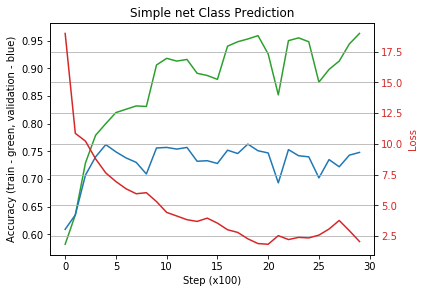

In [30]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

In [31]:
# net_simple_filename = "net_simple.ckpt"
# torch.save(net_simple.state_dict(), net_simple_filename)

#### Siamese network

In [32]:
epochs_grid_search = 25
epochs_train = 30

In [33]:
model_class = NetSiamese
criterion = siamese_model_criterion
lr_siamese_net_all = []
reg_siamese_net_all = []

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}

    lr_siamese_net, reg_siamese_net = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                  [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                  train, train_loader, test_loader, device, 
                                                  model_class, model_params, criterion, 
                                                  epochs=epochs_grid_search, print_info=True)
    lr_siamese_net_all.append(lr_siamese_net)
    reg_siamese_net_all.append(reg_siamese_net)

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.550
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.814
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.765
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.826
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.857
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.822
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.837
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.845
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.836
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.834
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.845
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.842
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 10.9824, class train/test accuracy: 0.552/0.545 
Epoch 10/30, loss 10.9574, class train/test accuracy: 0.552/0.545 
Epoch 15/30, loss 9.8584, class train/test accuracy: 0.713/0.714 
Epoch 20/30, loss 6.8501, class train/test accuracy: 0.82/0.802 
Epoch 25/30, loss 6.6909, class train/test accuracy: 0.841/0.804 
Epoch 30/30, loss 5.8420, class train/test accuracy: 0.837/0.801 
Achieved accuracy: 0.814


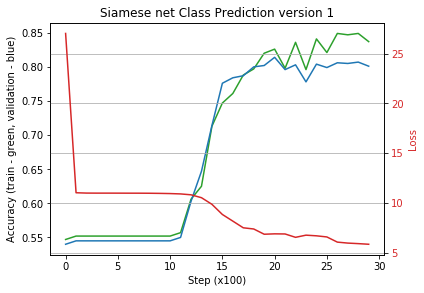

Siamese net version 2
Epoch 5/30, loss 7.1492, class train/test accuracy: 0.813/0.796 
Epoch 10/30, loss 5.8336, class train/test accuracy: 0.847/0.808 
Epoch 15/30, loss 5.0758, class train/test accuracy: 0.866/0.803 
Epoch 20/30, loss 4.1367, class train/test accuracy: 0.897/0.83 
Epoch 25/30, loss 4.1274, class train/test accuracy: 0.914/0.825 
Epoch 30/30, loss 3.6275, class train/test accuracy: 0.925/0.83 
Achieved accuracy: 0.832


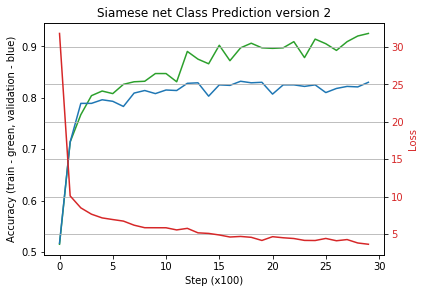

Siamese net version 3
Epoch 5/30, loss 8.1216, class train/test accuracy: 0.756/0.727 
Epoch 10/30, loss 6.6226, class train/test accuracy: 0.817/0.766 
Epoch 15/30, loss 5.7744, class train/test accuracy: 0.834/0.789 
Epoch 20/30, loss 5.2159, class train/test accuracy: 0.871/0.815 
Epoch 25/30, loss 4.7612, class train/test accuracy: 0.886/0.82 
Epoch 30/30, loss 4.4313, class train/test accuracy: 0.899/0.83 
Achieved accuracy: 0.833


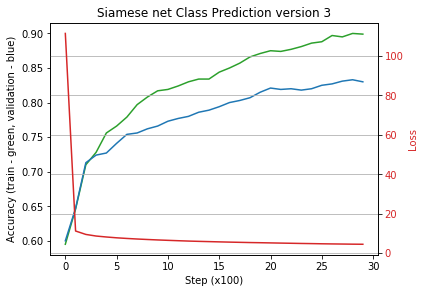

In [34]:
for i, ver in enumerate(siamese_net_versions):
    print(f"Siamese net version {ver}")
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)
    optimizer = optim.Adam(net_siamese.parameters(), lr=lr_siamese_net_all[i], weight_decay=reg_siamese_net_all[i])
    criterion = siamese_model_criterion

    net_siamese, accuracies, losses = train(train_loader, test_loader,
                                               net_siamese,
                                               optimizer, 
                                               criterion,
                                               device=device,
                                               epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"Siamese net Class Prediction version {ver}")

In [35]:
# siamese_net_filename = "net_siamese_loss.ckpt"
# torch.save(net_siamese.state_dict(), siamese_net_filename)

#### Auxiliary loss

In [41]:
epochs_grid_search = 25
epochs_train = 30

In [42]:
best_lambda = 5

In [43]:
model_class = NetSiamese
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)
lr_auxiliary_loss_all = []
reg_auxiliary_loss_all = []

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "auxiliary_loss": True,
                    "version": ver}

    lr_auxiliary_loss, reg_auxiliary_loss = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                          [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                          train, train_loader, test_loader, device, 
                                                          model_class, model_params, criterion, 
                                                          epochs=epochs_grid_search, print_info=True)
    
    lr_auxiliary_loss_all.append(lr_auxiliary_loss)
    reg_auxiliary_loss_all.append(reg_auxiliary_loss)

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.853
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.860
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.847
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.804
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.851
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.861
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.843
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.872
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.871
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.868
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.883
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.846
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.842
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.830
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 117.6872, class train/test accuracy: 0.62/0.623 , digit train/test accuracy: 0.3835/0.389
Epoch 10/30, loss 54.4406, class train/test accuracy: 0.832/0.815 , digit train/test accuracy: 0.775/0.7865
Epoch 15/30, loss 31.6599, class train/test accuracy: 0.907/0.845 , digit train/test accuracy: 0.884/0.8555
Epoch 20/30, loss 24.6833, class train/test accuracy: 0.924/0.859 , digit train/test accuracy: 0.864/0.8375
Epoch 25/30, loss 20.8420, class train/test accuracy: 0.944/0.859 , digit train/test accuracy: 0.889/0.854
Epoch 30/30, loss 17.2587, class train/test accuracy: 0.959/0.872 , digit train/test accuracy: 0.872/0.8445
Achieved accuracy: 0.874


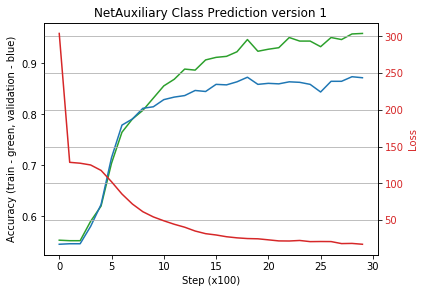

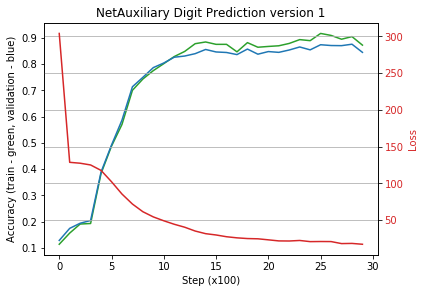

Siamese net version 2
Epoch 5/30, loss 107.3581, class train/test accuracy: 0.73/0.739 , digit train/test accuracy: 0.393/0.365
Epoch 10/30, loss 43.8705, class train/test accuracy: 0.88/0.831 , digit train/test accuracy: 0.803/0.7925
Epoch 15/30, loss 25.8779, class train/test accuracy: 0.938/0.847 , digit train/test accuracy: 0.8245/0.7865
Epoch 20/30, loss 25.3998, class train/test accuracy: 0.951/0.867 , digit train/test accuracy: 0.861/0.832
Epoch 25/30, loss 17.4638, class train/test accuracy: 0.973/0.859 , digit train/test accuracy: 0.916/0.872
Epoch 30/30, loss 17.0406, class train/test accuracy: 0.977/0.867 , digit train/test accuracy: 0.8985/0.8475
Achieved accuracy: 0.872


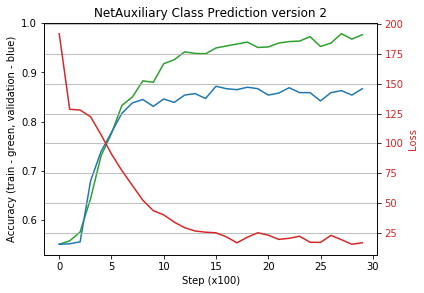

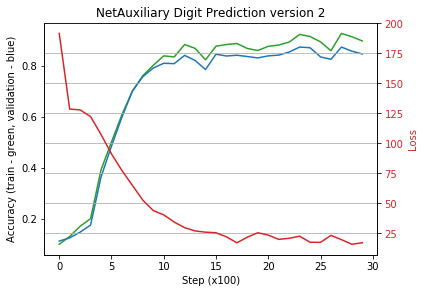

Siamese net version 3
Epoch 5/30, loss 88.5684, class train/test accuracy: 0.796/0.789 , digit train/test accuracy: 0.5275/0.5335
Epoch 10/30, loss 49.5292, class train/test accuracy: 0.868/0.849 , digit train/test accuracy: 0.7905/0.79
Epoch 15/30, loss 40.5207, class train/test accuracy: 0.91/0.869 , digit train/test accuracy: 0.8415/0.825
Epoch 20/30, loss 30.9834, class train/test accuracy: 0.904/0.861 , digit train/test accuracy: 0.8535/0.8345
Epoch 25/30, loss 31.5319, class train/test accuracy: 0.919/0.86 , digit train/test accuracy: 0.8625/0.85
Epoch 30/30, loss 33.9639, class train/test accuracy: 0.916/0.868 , digit train/test accuracy: 0.8725/0.8515
Achieved accuracy: 0.874


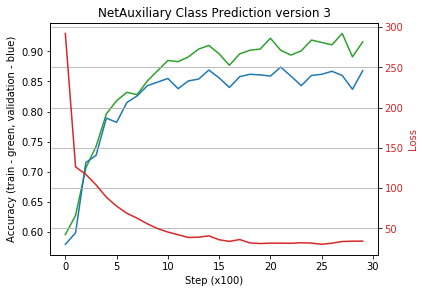

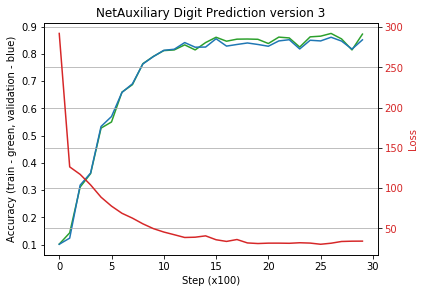

In [44]:
for i, ver in enumerate(siamese_net_versions):
    print(f"Siamese net version {ver}")
    net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=ver)
    optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss_all[i], weight_decay=reg_auxiliary_loss_all[i])
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                                   net_auxiliary_loss,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"NetAuxiliary Class Prediction version {ver}")
    plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, 
                           title=f"NetAuxiliary Digit Prediction version {ver}")

In [45]:
# net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
# torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

#### Digit prediction

In [36]:
epochs_grid_search = 25
epochs_train = 30

In [37]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "auxiliary_loss": True,
                "version": 4}
criterion = digit_prediction_criterion

lr_digit_prediction, reg_digit_prediction = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                      train, train_loader, test_loader, device, 
                                                      model_class, model_params, criterion, 
                                                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.907
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.920
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.919
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.885
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.952
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.938
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.946
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.933
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.915
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.935
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.930
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.921
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.947
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.935
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.920
Learning r

Let's see the model's perfomance

In [38]:
net_digit_prediction = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=4)
optimizer = optim.Adam(net_digit_prediction.parameters(), lr=lr_digit_prediction, weight_decay=reg_digit_prediction)
criterion = digit_prediction_criterion

net_digit_prediction, accuracies, losses = train(train_loader, test_loader,
                                                   net_digit_prediction,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 23.3423, class train/test accuracy: 0.877/0.884 , digit train/test accuracy: 0.8045/0.782
Epoch 10/30, loss 13.3433, class train/test accuracy: 0.913/0.913 , digit train/test accuracy: 0.883/0.855
Epoch 15/30, loss 9.9452, class train/test accuracy: 0.942/0.922 , digit train/test accuracy: 0.915/0.8855
Epoch 20/30, loss 9.1282, class train/test accuracy: 0.93/0.916 , digit train/test accuracy: 0.912/0.884
Epoch 25/30, loss 8.1386, class train/test accuracy: 0.957/0.94 , digit train/test accuracy: 0.938/0.916
Epoch 30/30, loss 6.6950, class train/test accuracy: 0.957/0.94 , digit train/test accuracy: 0.9265/0.907
Achieved accuracy: 0.946


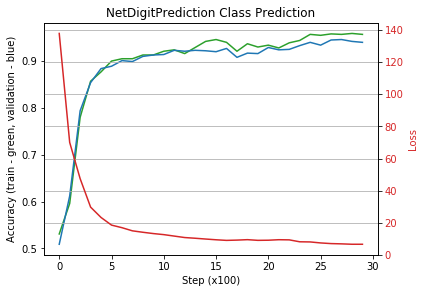

In [39]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetDigitPrediction Class Prediction")

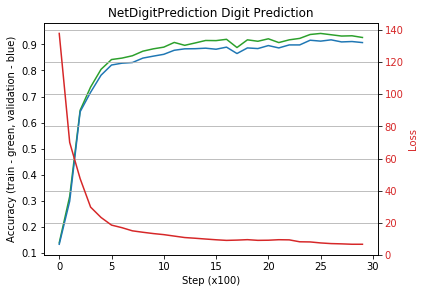

In [40]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetDigitPrediction Digit Prediction")

From these plots we can derive two observations:
* Simple and Siamese models overfit on class prediction and don't overfit on digit prediction
* Siamese network of version 4 is not overfitting at all. That may mean that overfitting in siamese networks is caused by last layers responsible for predicting class from digit's encodings.
* Siamese models' capacity is enough for getting at most accuracy of level approximately 95%. We can use this result as benchmark for another versions of Siamese model. Also, we don't need to add more capacity to siamese network.

### Test

#### Simple net

In [46]:
# checkpoint = torch.load(net_simple_filename)
# net_simple = NetSimple(input_channels, output_class_channels)
# net_simple.load_state_dict(checkpoint)
# # net_simple.to(device)

In [47]:
# test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

In [48]:
# checkpoint = torch.load(siamese_net_filename)
# net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
# net_siamese.load_state_dict(checkpoint)
# # net_simple.to(device)

In [49]:
# test_samples(net_siamese, test_input, test_class, test_digit)

#### Auxiliary loss

In [50]:
# checkpoint = torch.load(net_auxiliary_loss_filename)
# net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
# net_auxiliary_loss.load_state_dict(checkpoint)
# # net_simple.to(device)

In [51]:
# test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.

In [52]:
nb_tests = 20
epochs_train = 40
N = 1000

#### Simple net

In [53]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

accuracy_values_simple_net, loss_values_simple_net = test_model(train, generate_data, device,
                                                                model_class, model_params, criterion, 
                                                                lr_simple_net, reg_simple_net,
                                                                nb_tests=nb_tests, epochs=epochs_train)

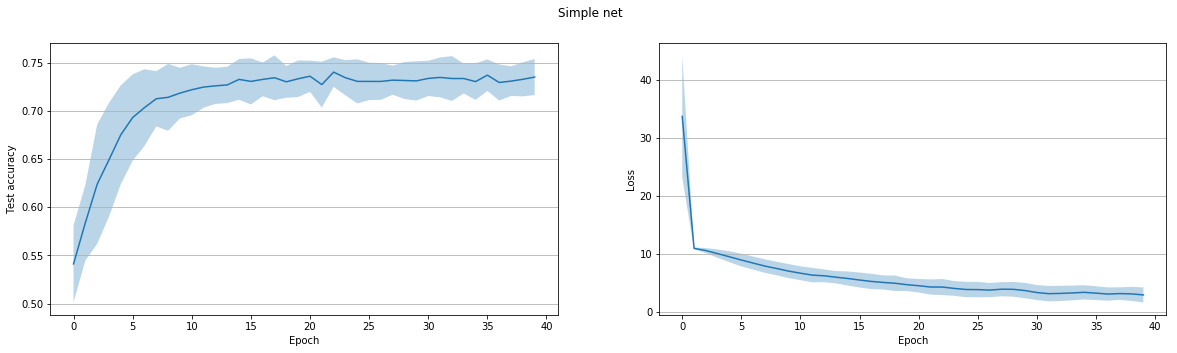

In [54]:
plot_test_results(accuracy_values_simple_net, loss_values_simple_net, title="Simple net")

#### Siamese Net 

Let's try different versions of siamese network

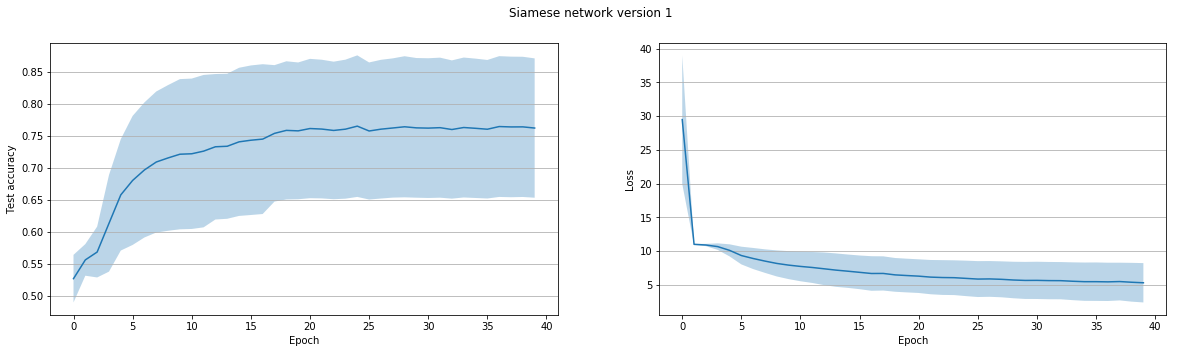

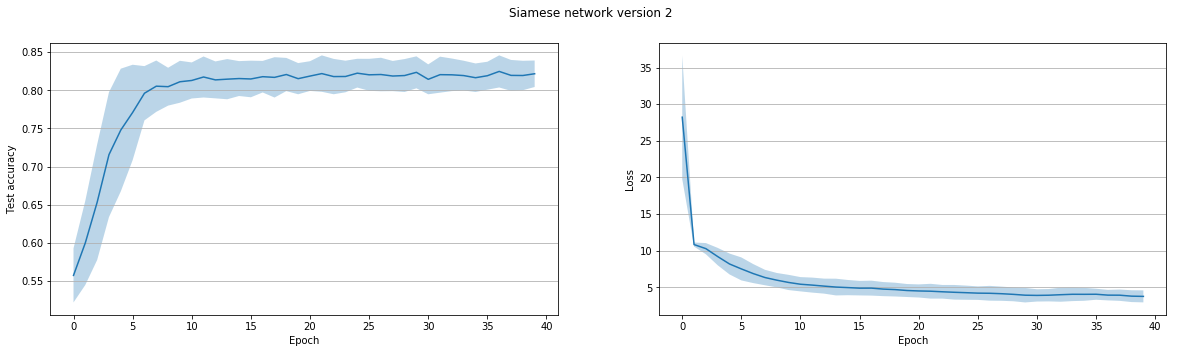

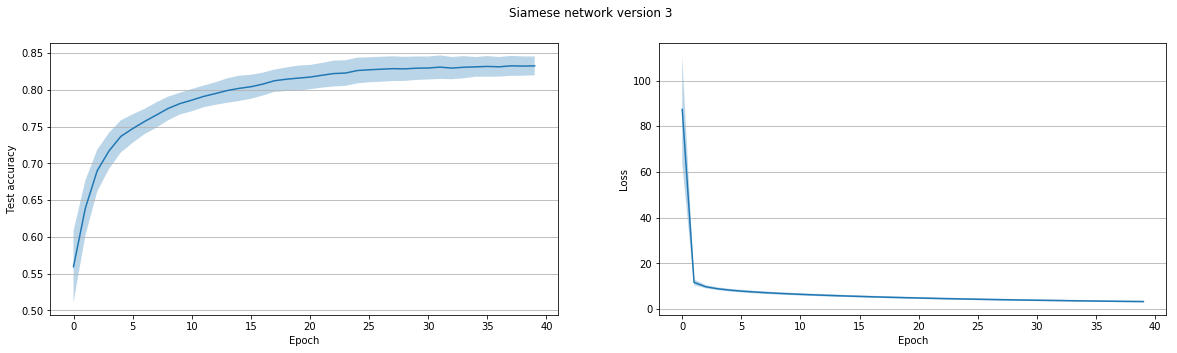

In [55]:
for i, ver in enumerate(siamese_net_versions): 
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}
    criterion = siamese_model_criterion
    
    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_siamese_net_all[i], reg_siamese_net_all[i],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network version {ver}")

We see that model version 1 has std greater than another versions. It can be caused by the way we connect subnetworks. In version 1 we concatenate 10x1 vectors of digit predictions and then try to predict class from 20x1 vector. In version 2 and 3 we try to predict class from vector obtained either by concatenation of digits' encodings or difference between digit's encodings, which might be more robust.

#### Net for digit prediction

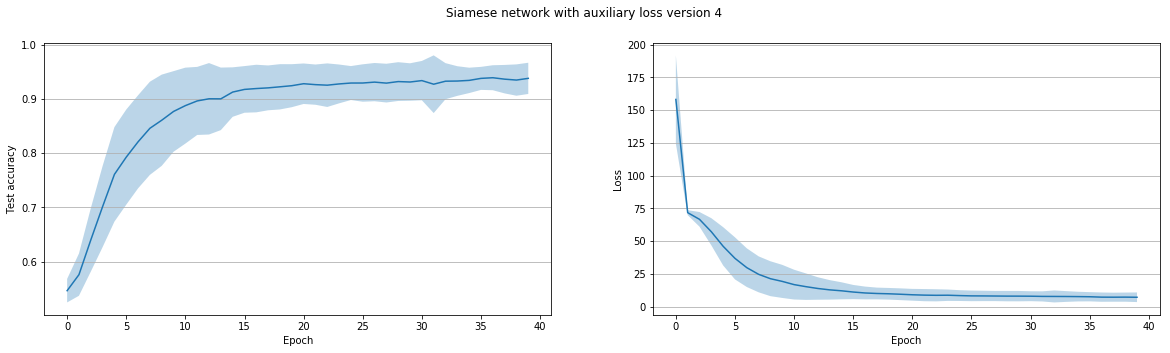

In [56]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "version": 4,
                "auxiliary_loss": True}
criterion = digit_prediction_criterion

accuracy_values, loss_values = test_model(train, generate_data, device,
                                            model_class, model_params, criterion, lr_digit_prediction, reg_digit_prediction,
                                            nb_tests=nb_tests, epochs=epochs_train)

plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {4}")

#### Net with AuxiliaryLoss

Let's try different versions of siamese network

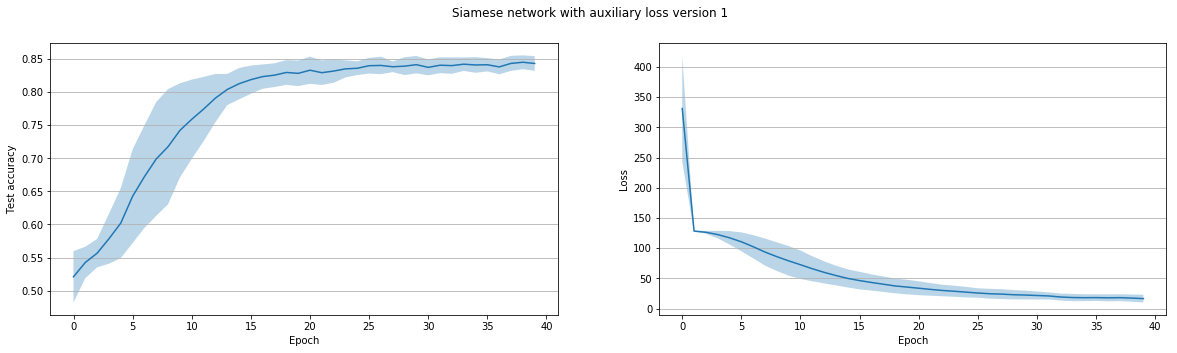

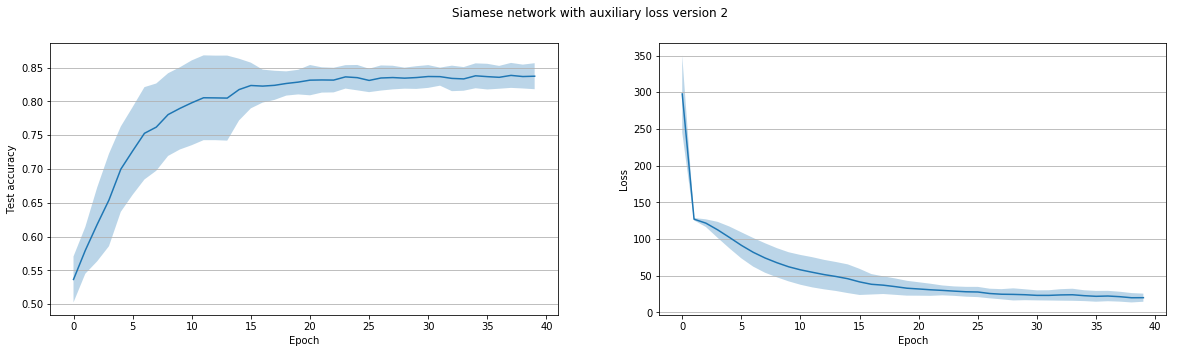

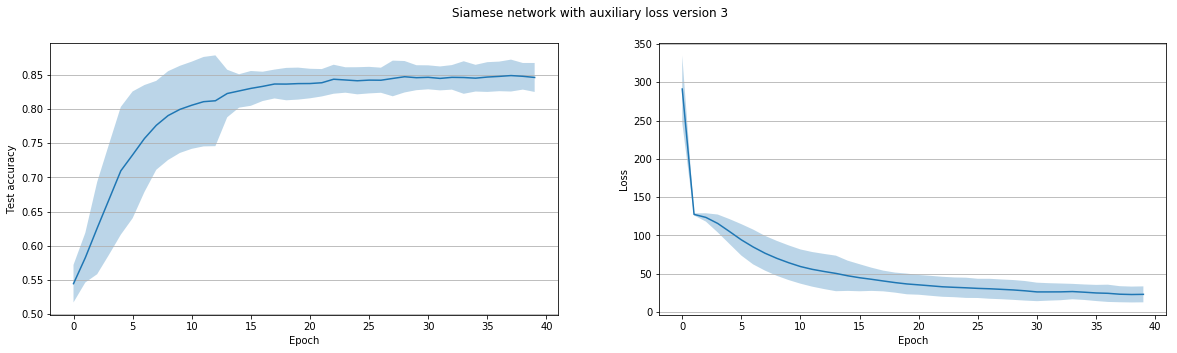

In [57]:
for i, ver in enumerate(siamese_net_versions):
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_auxiliary_loss_all[i], reg_auxiliary_loss_all[i],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {ver}")

We see that simple net model have accuracy below 75%. Then, turning to siamese arhictecture we increase accuracy to level between 82.5% and 85%. Finnaly, after adding additional loss for sample's both digit prediction we got accuracy approximately 85%.

#### Oversampling or Undersampling

Let's try apply dataset balancing technique for best model to see wheither we can improve obtained results.

### Results

#### Simple net

#### Siamese net

#### Net with AuxiliaryLoss

### Model's visualisation

In [58]:
# !pip install graphviz

In [59]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

In [60]:
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [61]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

In [62]:
plot_model_architecture = False

In [63]:
if plot_model_architecture:
    filename = "Simple net"

    inputs = torch.randn(1, 2, 14, 14)
    y = net_simple(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_simple.named_parameters()))
    g.view(filename)

In [64]:
if plot_model_architecture:
    ver = 2
    filename = f"Siamese version {ver}"
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)

    inputs = torch.randn(1, 2, 14, 14)
    y = net_siamese(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_siamese.named_parameters()))
    g.view(filename)